# Анализ продаж компьютерных игр

# Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. 

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

# Описание данных

    Name — название игры
    Platform — платформа
    Year_of_Release — год выпуска
    Genre — жанр игры
    NA_sales — продажи в Северной Америке (миллионы проданных копий)
    EU_sales — продажи в Европе (миллионы проданных копий)
    JP_sales — продажи в Японии (миллионы проданных копий)
    Other_sales — продажи в других странах (миллионы проданных копий)
    Critic_Score — оценка критиков (максимум 100)
    User_Score — оценка пользователей (максимум 10)
    Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

# План

1. Знакомство с данными
2. Предварительная обработка данных
3. Работа с пропущенными значениям
4. Устранение дубликатов
5. Добавление нового столбца (общих продаж по всем регионам)
6. Провести анализ общих продаж и выделить периоды пикового спроса на игры.
7. Определить актуальный период для более детального анализа.
8. Выделить наиболее перспективные платформы.
9. Анализ выпуска игр по годам 
10. Анализ продаж по платформам
11. Оценка влияния отзывов и анализ жанров
12. Исследовать популярность платформ в различных регионах.
13. Выделить особенности предпочтений игроков в Северной Америке, Европе и Японии.
14. Проверка гипотез

## Загрузка данных и первое знакомство

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

In [2]:
df = pd.read_csv(r"D:\Загрузки\games.csv")

In [3]:
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Вывод

Видим много пропущенных значений в столбцах с оценками и рейтингом, также есть несоответствие типов данных в столбцах User_Score, Year_of_Release. Столбцы следует переименовать.

## Подготовка данных

### Заменим названия столбцов  и типы данных


In [5]:
df.columns = df.columns.str.lower()

In [6]:
# в столбце 'user_score' видим tbd (от англ. to be determined). То есть оценки здесь неизвестны - заменим на None
df['user_score'] = df['user_score'].replace('tbd', None)

In [7]:
df['user_score'] = df['user_score'].astype('float')
df['year_of_release'] = pd.to_datetime(df['year_of_release'], format='%Y').dt.year

###   Обработка пропусков

In [8]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (10,5), legend = False, fontsize = 16)
                
        )
        plt.title('Пропущенные значения, %' + "\n", fontsize=15)
        plt.xlabel('Процент пропусков')
        plt.ylabel('Столбцы с пропусками')
        plt.xlim(0, 100);    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

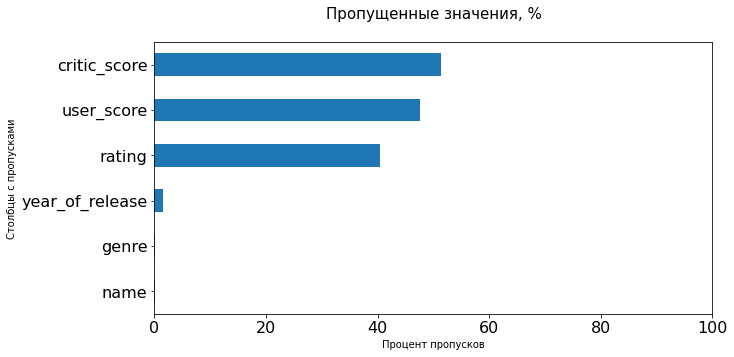

In [9]:
pass_value_barh(df)

***В колонках 'genre' и 'name' очень маленькое количество пропусков, можем их удалить***

In [10]:
df.dropna(subset=['genre'], inplace=True)
df.dropna(subset=['name'], inplace=True)

In [11]:
# check
# жизненный срок платформы

years_of_life = df.pivot_table(index='platform',values='year_of_release',aggfunc=['min','max'])
years_of_life.columns=['min','max']
years_of_life['years_of_life']=years_of_life['max']-years_of_life['min']
years_of_life

# years_of_life.sort_values(by = 'years_of_life', ascending = False)

,min,max,years_of_life
platform,,,
2600,1980.0,1989.0,9.0
3DO,1994.0,1995.0,1.0
3DS,2011.0,2016.0,5.0
DC,1998.0,2008.0,10.0
DS,1985.0,2013.0,28.0
GB,1988.0,2001.0,13.0
GBA,2000.0,2007.0,7.0
GC,2001.0,2007.0,6.0
GEN,1990.0,1994.0,4.0


In [12]:
df.loc[df['year_of_release'].isna()]['platform'].value_counts()

PS2     34
Wii     34
DS      30
X360    30
PS3     25
XB      21
2600    17
PC      17
PSP     16
GC      14
GBA     11
3DS      8
PS       7
N64      3
GB       1
PSV      1
Name: platform, dtype: int64

***Пустые значения в колонке года удалим, т.к. их доля невелика***

In [13]:
df = df.dropna(subset=['year_of_release'])

In [14]:
# check
# жизненный срок платформы

years_of_life = df.pivot_table(index='platform',values='year_of_release',aggfunc=['min','max'])
years_of_life.columns=['min','max']
years_of_life['years_of_life']=years_of_life['max']-years_of_life['min']
years_of_life


,min,max,years_of_life
platform,,,
2600,1980.0,1989.0,9.0
3DO,1994.0,1995.0,1.0
3DS,2011.0,2016.0,5.0
DC,1998.0,2008.0,10.0
DS,1985.0,2013.0,28.0
GB,1988.0,2001.0,13.0
GBA,2000.0,2007.0,7.0
GC,2001.0,2007.0,6.0
GEN,1990.0,1994.0,4.0


In [15]:
df = df.reset_index(drop=True)

***Пустые значения в колонке рейтинг заменим на 'unknown'***

In [16]:
df['rating'] = df['rating'].fillna('unknown')

### Поиск дубликатов

In [17]:
display(df.loc[df.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
600,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
15969,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


In [18]:
df.loc[600, 'eu_sales'] = 0.23
df = df.drop (15969)

In [19]:
df = df.reset_index(drop=True)

In [20]:
sorted(df['platform'].unique())

['2600',
 '3DO',
 '3DS',
 'DC',
 'DS',
 'GB',
 'GBA',
 'GC',
 'GEN',
 'GG',
 'N64',
 'NES',
 'NG',
 'PC',
 'PCFX',
 'PS',
 'PS2',
 'PS3',
 'PS4',
 'PSP',
 'PSV',
 'SAT',
 'SCD',
 'SNES',
 'TG16',
 'WS',
 'Wii',
 'WiiU',
 'X360',
 'XB',
 'XOne']

### Расчет суммарных продаж

In [21]:
df['total_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16438,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16439,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,unknown,0.01
16440,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16441,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,unknown,0.01


#### Вывод 

Изменили названия столбцов.

Преобразовали типы данных в столбцах user_score, year_of_release.

Заполнили пропуски в столбце year_of_release на основе данных о дате выхода игр на других платформах, в столбце rating изменили на 'unknown'. Пропуски в столбцах name и genre удалили, т.к. они составляют совсем небольшую часть.

Пропуски в оценках оставили без изменений. Также в оценке пользователей 'tbd' заменили на пропуск, т.к. эта аббревиатура означает, что оценка пока не поставлена.

Пропуски в столбцах могут возникнуть из-за технических проблем. Возможно игры не пользуются достаточной популярностью, из-за чего оценка в ретинге не стоит.

Заметили дубликаты в двух строках, объединили в каждой данные по продажам в регионах.

Создали отдельный столбец с общими продажами.

In [22]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  float64
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       8608 non-null   float64
 10  rating           16443 non-null  object 
 11  total_sales      16443 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.5+ MB


## Исследовательский анализ данных

### Выпуск игр по годам


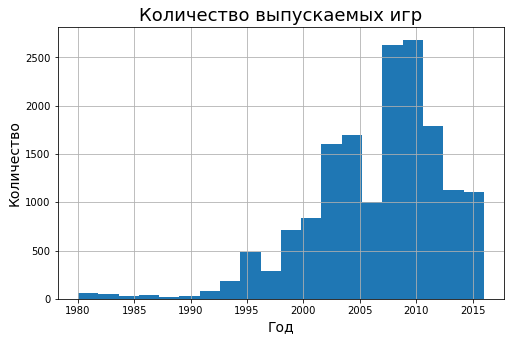

In [23]:
df['year_of_release'].hist(bins=20, figsize=(8, 5))
plt.title('Количество выпускаемых игр', fontsize=18)
plt.ylabel('Количество', fontsize=14)
plt.xlabel('Год', fontsize=14)
plt.show()

***Количество выпускаемых игр увеличивается с 1990 года, достигая максимума около 2010 года, а затем снижается.***

### Как менялись продажи по платформам. За какой характерный срок появляются новые и исчезают старые платформы?


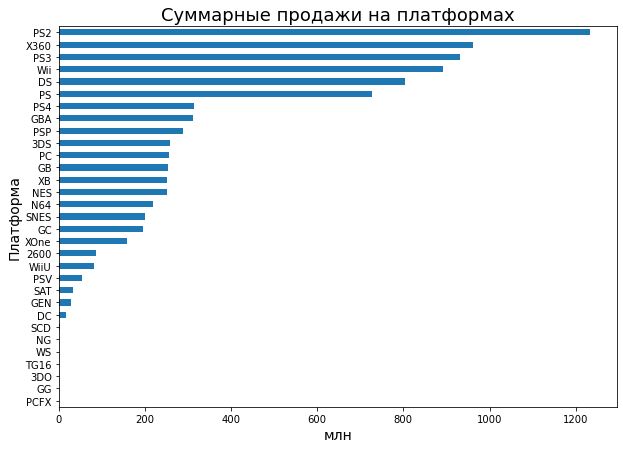

In [24]:
(df.pivot_table(index='platform', aggfunc='sum', values='total_sales')
    .sort_values(by='total_sales')
    .plot(kind='barh', figsize=(10, 7), legend=False))
plt.title('Суммарные продажи на платформах', fontsize=18)
plt.ylabel('Платформа', fontsize=14)
plt.xlabel('млн', fontsize=14)
plt.show()

***Наибольшие продажи на платформах PS2, X360, PS3, Wii, DS, PS.***

In [25]:
df_top_platform = df[df['platform'].isin(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'])]

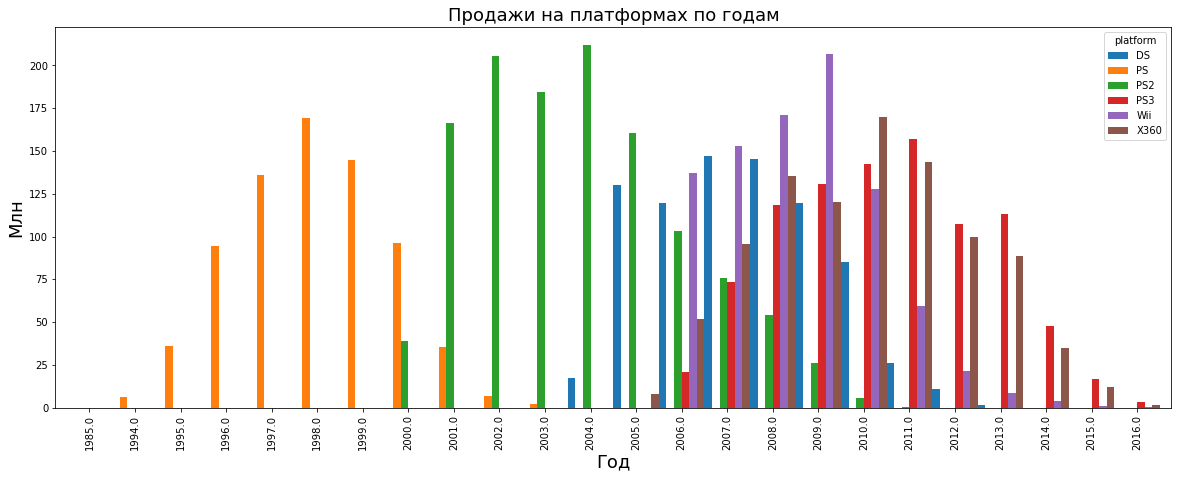

In [26]:
(df_top_platform.pivot_table(index='year_of_release', columns='platform', aggfunc='sum', values='total_sales')
    .plot(kind='bar', figsize=(20, 7), width=1))

plt.title('Продажи на платформах по годам', fontsize=18)
plt.ylabel('Млн', fontsize=18)
plt.xlabel('Год', fontsize=18)
plt.show()

***Заметно, что в основном платформы "живут" около 10 лет. Также видим, что популярность платформ, а соответственно и игр начинается с 1994 года.***

In [27]:
df_top_platform.loc[df_top_platform['year_of_release'] == 1985]
# DS была выпущена в 2004 году, удалим.

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15704,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,unknown,0.02


In [28]:
df = df.drop(index=df.query('year_of_release == 1985 and platform =="DS"').index)

   ### Определение актуального периода 

Возьмем данные за предыдущие два года

In [29]:
df = df[df['year_of_release'] >=2014]

### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.


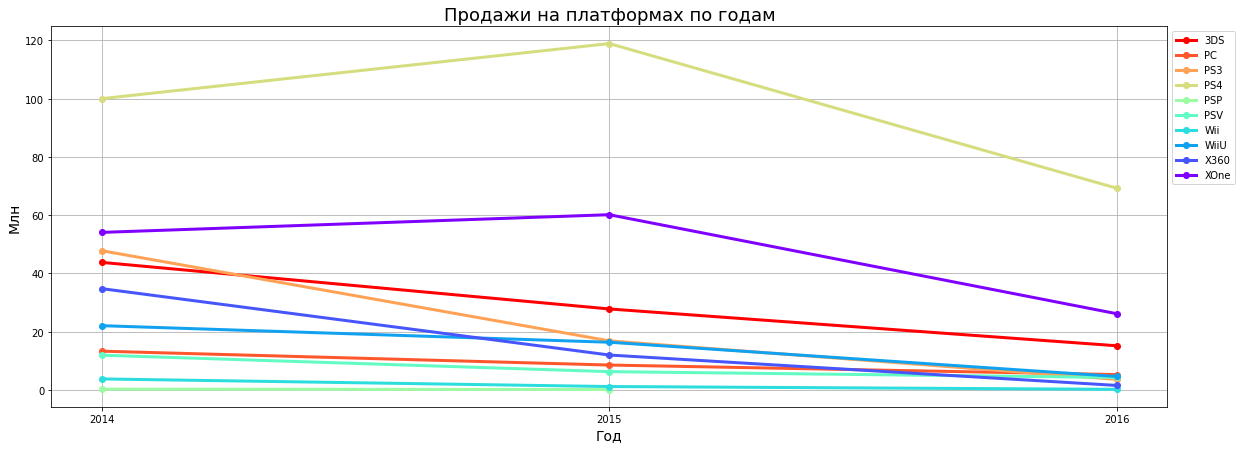

In [30]:
(df.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
    .plot(figsize=(20, 7), grid = True, style='o-', colormap='rainbow_r', linewidth=3)
    .legend(loc='upper left', bbox_to_anchor=(1, 1)))
plt.title('Продажи на платформах по годам', fontsize=18)
plt.ylabel('Млн', fontsize=14)
plt.xlabel('Год', fontsize=14)
plt.xticks(np.arange(2014, 2017))
plt.show()

***Высокие продажи заметны на платформах PS4 и XOne.***

***Продажи на других платформах в 2015 упали по сравнению с 2014***

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.


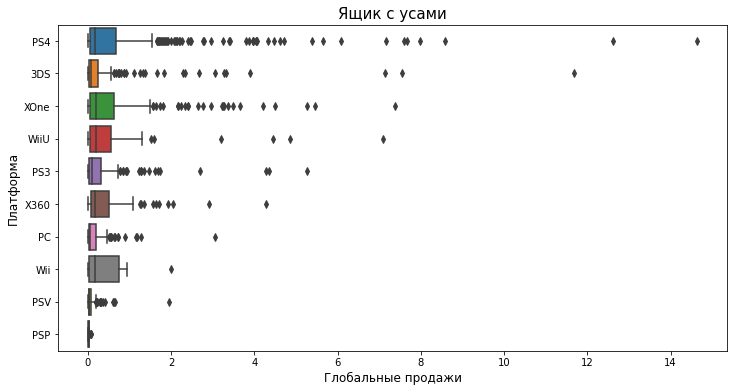

In [31]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, y='platform', x='total_sales', orient='h')
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Глобальные продажи', fontsize=12)
plt.ylabel('Платформа',fontsize=12)
plt.show()

***Заметны сильные выбросы, а сами ящики очень сжаты. Посмотрим без выбросов.***

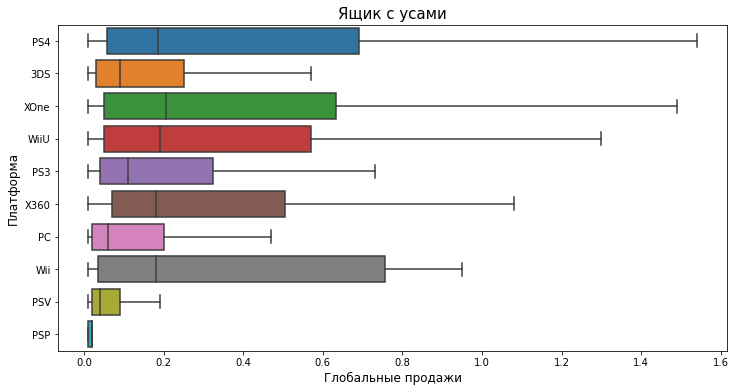

In [32]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, y='platform', x='total_sales', orient='h', showfliers=False)
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Глобальные продажи', fontsize=12)
plt.ylabel('Платформа',fontsize=12)
plt.show()

***Больше всего продаж за актуальный период приходятся на платформы XOne и PS4.***

***Размах для этих консолей также достаточно большой, что говорит о наличии большого количества продаж. Также видим большие продажи на платформах WiiU, X360, однако, исходя из предыдущего графика, их востребованность уже падает.***

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.


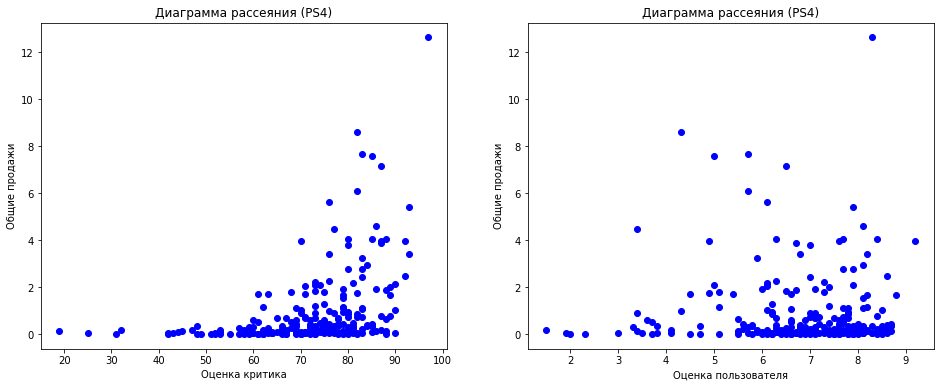

Коэффициент корреляции (критики): 0.4
Коэффициент корреляции (пользователи): -0.04


In [33]:
df_PS4 = df[df['platform'] == 'PS4']
f, ax = plt.subplots(1,2)
f.set_size_inches(16,6)

ax[0].scatter(x='critic_score', y='total_sales', data=df_PS4, c='b')
ax[0].set_xlabel('Оценка критика')
ax[0].set_ylabel('Общие продажи')
ax[0].set_title('Диаграмма рассеяния (PS4)')

ax[1].scatter(x=df_PS4['user_score'], y=df_PS4['total_sales'], c='b')
ax[1].set_xlabel('Оценка пользователя')
ax[1].set_ylabel('Общие продажи')
ax[1].set_title('Диаграмма рассеяния (PS4)')

plt.show()

print('Коэффициент корреляции (критики):', df_PS4['total_sales'].corr(df_PS4['critic_score']).round(decimals=2))
print('Коэффициент корреляции (пользователи):', df_PS4['total_sales'].corr(df_PS4['user_score']).round(decimals=2))

***Мы видим положительную корреляцию между оценкой критика и количеством продаж, но точно сказать, влияет ли он на продажи нельзя. Оценнка пользователей не связана с продажами.***

### Соотнесите выводы с продажами игр на других платформах.


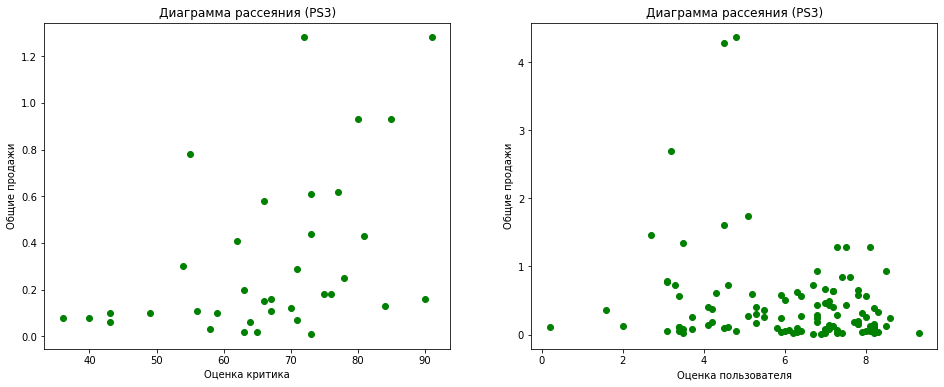

Коэффициент корреляции (критики): 0.45
Коэффициент корреляции (пользователи): -0.19


In [34]:
df_PS3 = df[df['platform']=='PS3']
f, ax = plt.subplots(1,2)
f.set_size_inches(16,6)

ax[0].scatter(x='critic_score', y='total_sales', data=df_PS3, c='g')
ax[0].set_xlabel('Оценка критика')
ax[0].set_ylabel('Общие продажи')
ax[0].set_title('Диаграмма рассеяния (PS3)')

ax[1].scatter(x=df_PS3['user_score'], y=df_PS3['total_sales'], c='g')
ax[1].set_xlabel('Оценка пользователя')
ax[1].set_ylabel('Общие продажи')
ax[1].set_title('Диаграмма рассеяния (PS3)')

plt.show()

print('Коэффициент корреляции (критики):', df_PS3['total_sales'].corr(df_PS3['critic_score']).round(decimals=2))
print('Коэффициент корреляции (пользователи):', df_PS3['total_sales'].corr(df_PS3['user_score']).round(decimals=2))

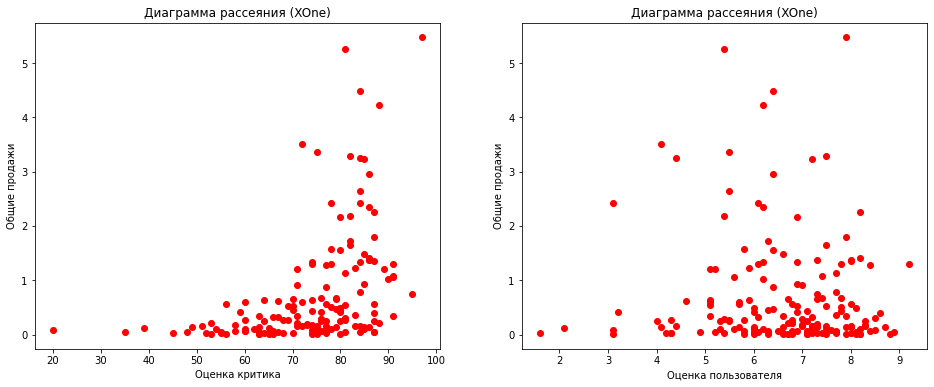

Коэффициент корреляции (критики): 0.43
Коэффициент корреляции (пользователи): -0.07


In [35]:
df_xone = df[df['platform']=='XOne']

f, ax = plt.subplots(1,2)
f.set_size_inches(16,6)

ax[0].scatter(x='critic_score', y='total_sales', data=df_xone, c='r')
ax[0].set_xlabel('Оценка критика')
ax[0].set_ylabel('Общие продажи')
ax[0].set_title('Диаграмма рассеяния (XOne)')

ax[1].scatter(x=df_xone['user_score'], y=df_xone['total_sales'], c='r')
ax[1].set_xlabel('Оценка пользователя')
ax[1].set_ylabel('Общие продажи')
ax[1].set_title('Диаграмма рассеяния (XOne)')

plt.show()

print('Коэффициент корреляции (критики):', df_xone['total_sales'].corr(df_xone['critic_score']).round(decimals=2))
print('Коэффициент корреляции (пользователи):', df_xone['total_sales'].corr(df_xone['user_score']).round(decimals=2))

***Как и следовало ожидать, оценки пользователей не влияют на количество продаж, а вот связь между продажами и оценками критиков существует, но точно оценить влияние мы, к сожалению, не можем.***

### Общее распределение игр по жанрам. 

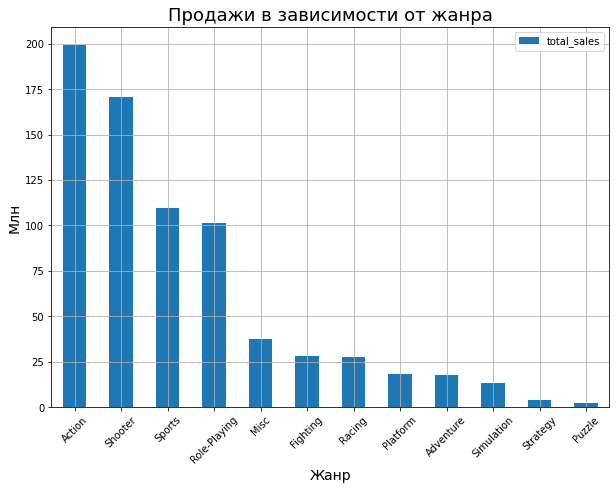

In [36]:
(df.pivot_table(index='genre', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .plot(kind='bar', figsize=(10, 7), grid = True, rot=45))
plt.title('Продажи в зависимости от жанра', fontsize=18)
plt.ylabel('Млн', fontsize=14)
plt.xlabel('Жанр', fontsize=14)
plt.show()

***Игры в жанре экшн продаются в большем количестве, за ними идут шутеры, РПГ и спорт. Внизу рейтинга находятся головоломки, стратегии и приключения.***

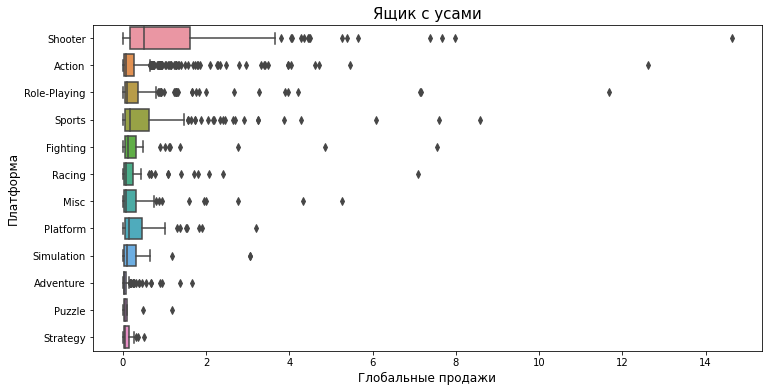

In [37]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, y='genre', x='total_sales', orient='h')
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Глобальные продажи', fontsize=12)
plt.ylabel('Платформа',fontsize=12)
plt.show()

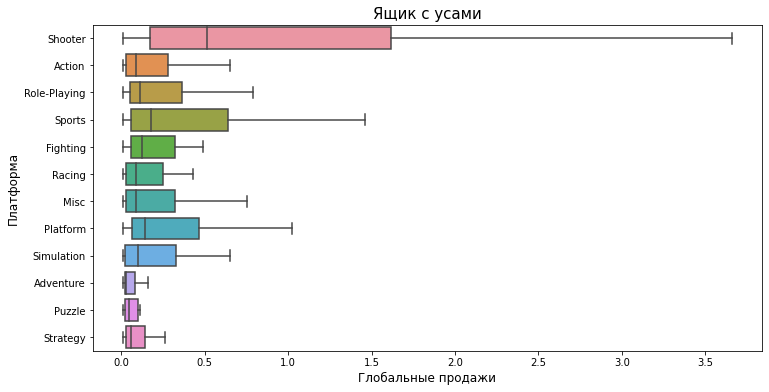

In [38]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, y='genre', x='total_sales', orient='h', showfliers=False)
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Глобальные продажи', fontsize=12)
plt.ylabel('Платформа',fontsize=12)
plt.show()

***Наибольшее медианное значение продаж мы видим в жанре shooter, здесь же заметен и "длинный ус", т.е. в этом жанре наблюдается и большой разброс значений, но все они являются нормальными.*** 

***Гистограмма выше нам показала, что больше продаж приносят игры в жанре экшн, однако теперь ясно, что такие высокие продажи - скорее единичные выбросы.*** 

***Таким образом, более "стабильным" жанром являются шутеры, затем следуют и сильно уступают им спортивные  игры***

#### Вывод

Количество выпускаемых игр увеличивается с 1990 года, достигая максимума около 2010 года, а затем снижается.

Заметили, что в основном жизненный цикл платформы длится около 10 лет. Принято взять 2 прошедших (полных) года в качестве актуального периода, чтобы было возможно продемонстрировать динамику, но и чтобы период не был слишком большим.

Наибольшие продажи за все время - на платформах PS2, X360, PS3, Wii, DS, PS.

В актуальном периоде высокие продажи заметны на платформах PS4 и XOne. Продажи на других платформах в 2015 упали по сравнению с 2014

Оценки пользователей не влияют на количество продаж, а вот небольшая связь между продажами и оценками критиков существует, но точно оценить влияние мы, к сожалению, не можем.

Более продаваемые игры - игры в жанре экшн, а менее - головоломки. Однако здесь не учитывается разброс данных. Если мы посмотрим на боксплот, то увидим, что высокие продажи игр в жанре экшн - не типичная, а достаточно редкая история, а наиболее стабильно продаваемые игры -в жанре шутера.

## Портрет пользователя каждого региона
### Самые популярные платформы (топ-5)

In [39]:
na_sales = df.groupby('platform')['na_sales'].sum().sort_values(ascending=False).reset_index()
eu_sales = df.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).reset_index()
jp_sales = df.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).reset_index()

In [40]:
# заменим все, что не входит в топ-5, на 'Другие'
na_sales.loc[~na_sales['platform'].isin(na_sales['platform'].head(5)), 'platform'] = 'Другие'
eu_sales.loc[~eu_sales['platform'].isin(eu_sales['platform'].head(5)), 'platform'] = 'Другие'
jp_sales.loc[~jp_sales['platform'].isin(jp_sales['platform'].head(5)), 'platform'] = 'Другие'

In [41]:
na_sales = na_sales.groupby('platform')['na_sales'].sum()
eu_sales = eu_sales.groupby('platform')['eu_sales'].sum()
jp_sales = jp_sales.groupby('platform')['jp_sales'].sum()

In [42]:
na_sales = na_sales.reset_index()
eu_sales = eu_sales.reset_index()
jp_sales = jp_sales.reset_index()

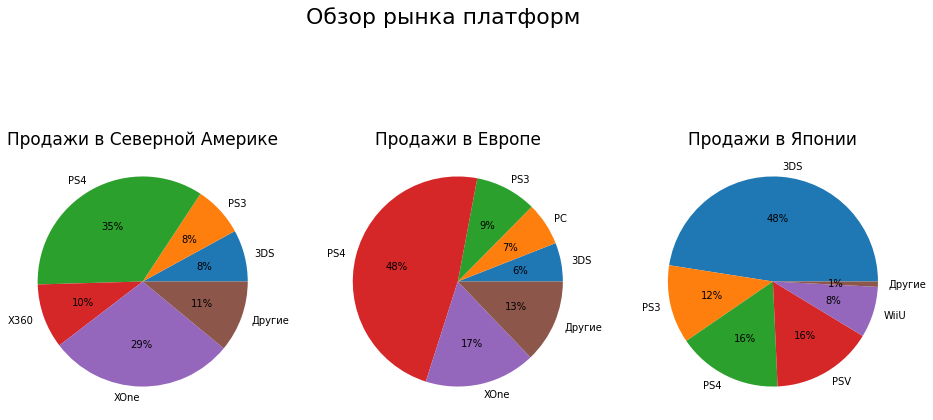

In [43]:
f, ax = plt.subplots(1,3)
f.set_size_inches(16,8)
ax[0].pie(na_sales['na_sales'], autopct = '%1.0f%%', labels=na_sales['platform'])
ax[1].pie(eu_sales['eu_sales'], autopct = '%1.0f%%', labels=eu_sales['platform'])
ax[2].pie(jp_sales['jp_sales'], autopct = '%1.0f%%', labels=jp_sales['platform'])

ax[0].set_title('Продажи в Северной Америке', fontsize=17)
ax[1].set_title('Продажи в Европе', fontsize=17)
ax[2].set_title('Продажи в Японии', fontsize=17)

f.suptitle('Обзор рынка платформ', fontsize=22)
plt.show()

***Самые популярные платформы***

Северная Америка:  PS4, XOne, X360, PS3, 3DS

Европа: PS4, XOne, PS3, PC, 3DS

Япония: 3DS, PSV, PS4, PS3, WiiU

### Самые популярные жанры (топ-5). 

In [44]:
na_genre = df.groupby('genre')['na_sales'].sum().sort_values(ascending=False).reset_index()
eu_genre = df.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).reset_index()
jp_genre = df.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).reset_index()

In [45]:
# заменим все, что не входит в топ-5, на 'Другие'
na_genre.loc[~na_genre['genre'].isin(na_genre['genre'].head(5)), 'genre'] = 'Другие'
eu_genre.loc[~eu_genre['genre'].isin(eu_genre['genre'].head(5)), 'genre'] = 'Другие'
jp_genre.loc[~jp_genre['genre'].isin(jp_genre['genre'].head(5)), 'genre'] = 'Другие'

In [46]:
na_genre = na_genre.groupby('genre')['na_sales'].sum()
eu_genre = eu_genre.groupby('genre')['eu_sales'].sum()
jp_genre = jp_genre.groupby('genre')['jp_sales'].sum()

In [47]:
na_genre = na_genre.reset_index()
eu_genre = eu_genre.reset_index()
jp_genre = jp_genre.reset_index()

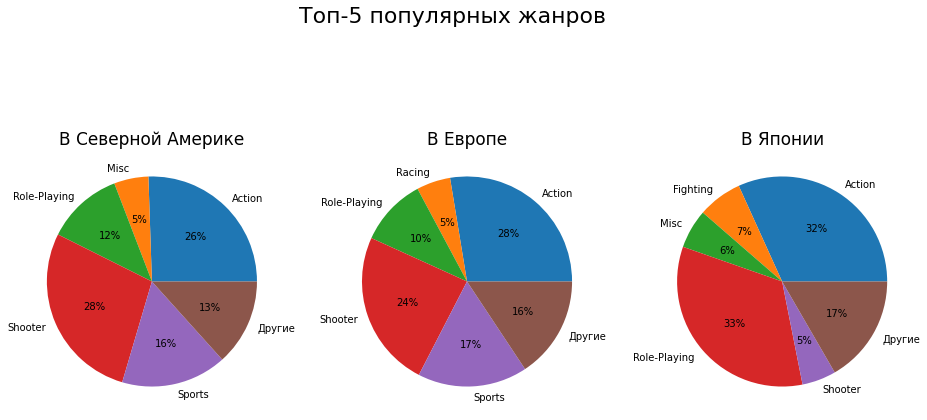

In [48]:
f, ax = plt.subplots(1,3)
f.set_size_inches(16,8)

ax[0].pie(na_genre['na_sales'], autopct = '%1.0f%%', labels=na_genre['genre'])
ax[1].pie(eu_genre['eu_sales'], autopct = '%1.0f%%', labels=eu_genre['genre'])
ax[2].pie(jp_genre['jp_sales'], autopct = '%1.0f%%', labels=jp_genre['genre'])

ax[0].set_title('В Северной Америке', fontsize=17)
ax[1].set_title('В Европе', fontsize=17)
ax[2].set_title('В Японии', fontsize=17)

f.suptitle('Топ-5 популярных жанров', fontsize=22)
plt.show()

***Самые популярные жанры***

Северная Америка: Shooter, Action, Sports, Role-Playing, Misc

Европа: Action, Shooter, Sports, Role-Playing, Racing

Япония: Role-Playing, Action, Fighting, Misc, Shooter

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

     

«E» («Everyone») — «Для всех»

«E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»

«T» («Teen») — «Подросткам»

«M» («Mature») — «Для взрослых»

In [49]:
df.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum()

,na_sales,eu_sales,jp_sales
rating,,,
E,50.74,58.06,8.94
E10+,33.23,26.16,4.46
M,96.42,93.44,8.01
T,38.95,34.07,14.78
unknown,64.72,58.95,56.90


In [50]:
na_esrb = df.groupby('rating')['na_sales'].sum().sort_values(ascending=False).reset_index()
eu_esrb = df.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).reset_index()
jp_esrb = df.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).reset_index()

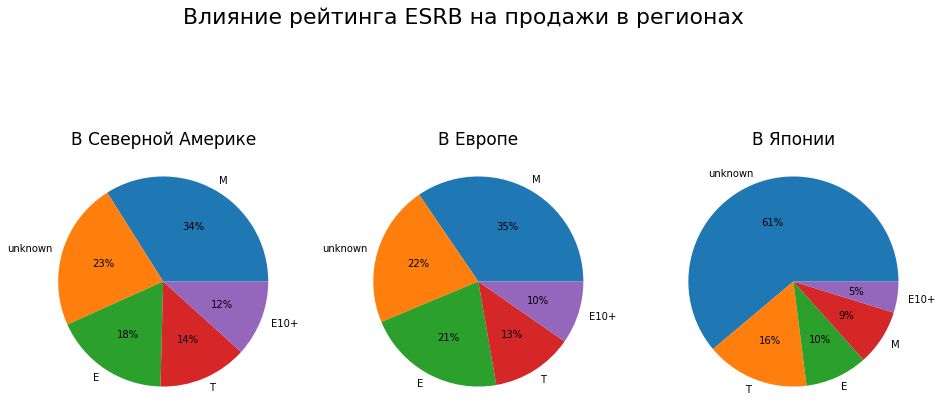

In [51]:
f, ax = plt.subplots(1,3)
f.set_size_inches(16,8)

ax[0].pie(na_esrb['na_sales'], autopct = '%1.0f%%', labels=na_esrb['rating'])
ax[1].pie(eu_esrb['eu_sales'], autopct = '%1.0f%%', labels=eu_esrb['rating'])
ax[2].pie(jp_esrb['jp_sales'], autopct = '%1.0f%%', labels=jp_esrb['rating'])

ax[0].set_title('В Северной Америке', fontsize=17)
ax[1].set_title('В Европе', fontsize=17)
ax[2].set_title('В Японии', fontsize=17)

f.suptitle('Влияние рейтинга ESRB на продажи в регионах', fontsize=22)
plt.show()

***Рейтинг ESRB***

Северная Америка: Для взрослых, Неизвестно, Для всех, Для подростков , Для всех от 10 лет и старше.

Европа: Для взрослых, Неизвестно, Для всех, Для подростков, Для всех от 10 лет и старше.

Япония: Неизвестно, Для подростков, Для всех, Для взрослых, Для всех от 10 лет и старше.

#### Вывод

1. Платформа

Видно, что в Северной Америке и Европе доминируют PS4 и XOne В Японии самой популярной является 3DS, при чем с достаточно большим отрывом, но также видно, что в стране пользуются и японской консолью wiiU.

2. Жанр

В Северной Америке самыми популярными жанрами являются Shooter, Action, Sports, Role-Playing, Misc, в Европе похожая ситуация, только вместо "разного" европейцы предпочитают гонки. В Японии видим достаточно отличающуюся картину: Role-Playing, Action, Fighting, Misc, Shooter. Такие различия могут быть связаны с культурными особенностями страны и иным менталитетом.

3. Рейтинг

В Северной Америке и Европе самой популярной категорией является M, что значит "Для взрослых", также преобладают игры для всех.
В Японии на первом месте "неизвестно". Возможно в Японии существует другой рейтинг для присваивания категорий играм, из-за чего указать точную категорию - сложно.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
    

H0: Средний пользовательский рейтинг платформы XOne **равен** среднему пользовательскому рейтингу платформы PC

H1: Средний пользовательский рейтинг платформы XOne **не равен** среднему пользовательскому рейтингу платформы PC

In [52]:
alpha=0.05
df_xone = df.query("platform == 'XOne' and user_score >= 0")
df_pc = df.query("platform == 'PC' and user_score >= 0")
print('Среднее значение рейтинга для XOne:', df_xone['user_score'].mean())
print('Среднее значение рейтинга для PC:', df_pc['user_score'].mean())
result = st.ttest_ind(df_xone['user_score'], df_pc['user_score'], equal_var=False)
print('Значение p-value:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее значение рейтинга для XOne: 6.597023809523808
Среднее значение рейтинга для PC: 6.314634146341461
Значение p-value: 0.13130164268727834
Не получилось отвергнуть нулевую гипотезу


In [53]:
display(df_xone['year_of_release'].max() - df_xone['year_of_release'].min())
display(df_pc['year_of_release'].max() - df_pc['year_of_release'].min())

2.0

2.0

***На первый взгляд, средние значения не сильно отличаются. И благодаря t-test  мы можем сказать, что среднее значение пользовательского рейтинга платформы Xbox One не отличается от среднего значения пользовательского рейтинга платформы PC.***

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

H0: Cредние пользовательские рейтинги жанра Action **равны**  средним пользовательским рейтингам жанра Sports

H1: Cредние пользовательские рейтинги жанра Action **не равны**  средним пользовательским рейтингам жанра Sports

In [55]:
alpha=0.05
df_action = df.query("genre == 'Action' and user_score >= 0")
df_sports = df.query("genre == 'Sports' and user_score >= 0")
print('Среднее значение рейтинга для Action:', df_action['user_score'].mean())
print('Среднее значение рейтинга для Sports:', df_sports['user_score'].mean())
result = st.ttest_ind(df_action['user_score'], df_sports['user_score'], equal_var=False)
print('Значение p-value:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее значение рейтинга для Action: 6.753354632587856
Среднее значение рейтинга для Sports: 5.291603053435112
Значение p-value: 1.3080710852425688e-13
Отвергаем нулевую гипотезу


***Можем сказать, что среднее значение пользовательской оценки для жанров Action и Sports не равны. А из вычисленных средних видно, что рейтинг у игр жанра Action выше.***

***Для проверки гипотезы был выбран тест о равенстве средних двух генеральных совокупностей с аргументом equal_var = False, т.к. размер совокупностей разный.***

## Общий вывод

В ходе анализа данных было обнаружено несколько ключевых моментов, которые требовали внимания и коррекции.

    Пропущенные значения и типы данных:
        Выявлено множество пропущенных значений в столбцах с оценками и рейтингом.
        Наблюдалось несоответствие типов данных в столбцах User_Score и Year_of_Release.
        Произведено переименование столбцов для улучшения читаемости.

    Обработка пропущенных значений:
        Пропуски в столбце Year_of_Release были заполнены на основе данных о дате выхода игр на других платформах.
        В столбце Rating пропуски были заменены на 'unknown'.
        Пропуски в столбцах Name и Genre удалены, поскольку их доля была невелика.
        Пропуски в оценках оставлены без изменений, а 'tbd' в столбце User_Score заменен на пропуск.

    Устранение дубликатов:
        Обнаружены дубликаты в двух строках, данные о продажах объединены.

    Создание дополнительных признаков:
        Добавлен столбец с общими продажами.
        Проанализировано количество выпущенных игр по годам.

    Анализ платформ:
        Установлено, что жизненный цикл платформы в основном составляет около 10 лет.
        Выделен актуальный период для анализа последних 2 полных лет (с 2014).
        Платформы-лидеры по продажам в актуальном периоде: PS4 и XOne.

    Корреляция и факторы успешности игр:
        Оценки пользователей не влияют на количество продаж.
        Наблюдается слабая связь между оценками критиков и продажами, но точно оценить влияние мы не можем.
        Более продаваемые игры обычно в жанре экшн, но стоит учитывать разброс данных.
        Жанр шутера имеет наиболее стабильные и высокие продажи.
    Популярные жанры:

        Более продаваемые игры обычно в жанре экшн, но стоит учитывать разброс данных.
        Жанр шутера имеет наиболее стабильные и высокие продажи.

    Региональные предпочтения:

        В Северной Америке и Европе доминируют PS4 и XOne, в Японии - 3DS с отрывом.
        Различия в предпочтениях могут быть обусловлены культурными особенностями.

    Рейтинги игр:

        В Северной Америке и Европе преобладают игры с рейтингом M (для взрослых), также популярны игры для всех.
        В Японии преобладают игры с неизвестным рейтингом.
        
    Статистические тесты:
        Средние значения пользовательского рейтинга платформ Xbox One и PC не различаются с высокой вероятностью.
        Средние значения пользовательской оценки для жанров Action и Sports различаются с высокой вероятностью.